# [TODO] compare for non-zero $k_x$

-> [DONE] done.

# [TODO] Implement winop for $n$ larger than 1

# [TODO] Check whether the W_root_plus and W_root_minus have same effect 

-> Yes, it seems so; the change of the sign doesn't seem to have effect on the resulting energy spectrum.

-> [TODO] need to be more rigorous to prove it
- [DONE] yes, it is because $\sqrt(W^{+})$ and $\sqrt(W^{-})$ are in conjugate transpose relation each other and commute each other. using this fact, it is possible to prove that the resulting energy spectrum are identical.
- [TODO] prove for $n > 1$ case

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.size'] = 13

# Configure Cooridnate

In [2]:
x_arr = np.linspace(-50,50,501)

# Define state function vector

In [3]:
sf_arr = np.empty_like(x_arr, dtype=complex)
from tdse.analytic import Gaussian1D
k_x = 1.0
sf_arr[:] = Gaussian1D(x_arr, t=0.0, k_x=k_x)

# Configure Hamiltonian

In [4]:
V_x_arr = np.zeros_like(x_arr, dtype=float)

# Configure window operator

In [5]:
winop_n=2
winop_gamma = 0.01

from nunit import au
au2ev = au.au2si['energy'] / au.e
print("Resolution: {:.2f} eV".format(winop_gamma * au2ev))

Resolution: 0.27 eV


# Construct energy array

In [6]:
E_min = -0.5
N_E = 150
E_arr = E_min + 2*winop_gamma*np.arange(N_E)

# Evaluate energy spectrum from `WINOP`

## Enlarge the spatial grid

In [7]:
# def enlarge_x_arr(N_plus, x_arr):
#     _N_winop = x_arr.size + 2*N_plus
#     _x_arr_winop = np.empty((_N_winop,), dtype=float)
#     _delta_x = x_arr[1] - x_arr[0]
#     _x_arr_winop[:N_plus] = x_arr[0] + np.arange(-N_plus,0) * _delta_x
#     _x_arr_winop[N_plus:_N_winop-N_plus] = x_arr
#     _x_arr_winop[_N_winop-N_plus:] = x_arr[-1] + np.arange(1,N_plus+1) * _delta_x
#     return _x_arr_winop

# def enlarge_arr(N_plus, arr):
#     _N_winop = x_arr.size + 2*N_plus
#     _arr_enlarged = np.zeros((_N_winop,), dtype=arr.dtype)
#     _arr_enlarged[N_plus:_N_winop-N_plus] = arr
#     return _arr_enlarged

from tdse.winop.resol import enlarge_x_arr, enlarge_arr

N_plus = 500
sf_arr_winop = enlarge_arr(N_plus, sf_arr)
V_x_arr_winop = enlarge_arr(N_plus, V_x_arr)
x_arr_winop = enlarge_x_arr(N_plus, x_arr)

## Evaluation

In [8]:
from tdse.winop import eval_energy_spectrum_for_1D_hamil
spectrum_E_arr = eval_energy_spectrum_for_1D_hamil(sf_arr_winop, x_arr_winop, V_x_arr_winop, E_arr, winop_n, winop_gamma)

# Comparison to analytical result

In [9]:
pos_E_arr = E_arr[E_arr > 0]
pos_k_arr = np.sqrt(2.0*pos_E_arr)
from tdse.analytic import Gaussian1D_k_t0
spectrum_E_ana_arr = 1.0/pos_k_arr * (
    np.square( np.abs(Gaussian1D_k_t0(pos_k_arr, k_x)) ) 
    + np.square( np.abs(Gaussian1D_k_t0(-pos_k_arr, k_x)) )
)

## Draw

### [TODO] The reason for oscillation in WINOP result

- the oscillation seems to increase its amplitude as gamma get smaller

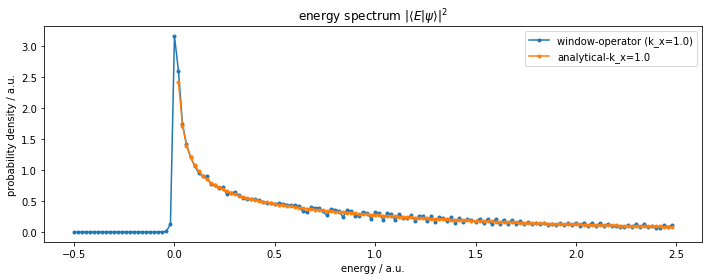

In [10]:
figE, axE = plt.subplots(figsize=(10,4))
li_winop, = axE.plot(E_arr, spectrum_E_arr, '.-')
li_ana, = axE.plot(pos_E_arr, spectrum_E_ana_arr, '.-')

axE.set_title(r"energy spectrum $|{\langle}E|\psi{\rangle}|^2$")
axE.set_xlabel("energy / a.u.")
axE.set_ylabel("probability density / a.u.")
axE.legend(
    (li_winop, li_ana), 
    ("window-operator (k_x={:.1f})".format(k_x), "analytical-k_x={:.1f}".format(k_x)))

figE.tight_layout()

In [11]:
# figE.savefig("winop-analytical-comparison-test-3-oscil-reduced-by-increased-xmax.png")

# Error analysis

In [12]:
# def eval_delta_E(E, x_arr):
#     _L = x_arr[-1] - x_arr[0]
#     _n = np.sqrt(2) * _L / np.pi * np.sqrt(E)
#     _delta_E = np.pi**2 * 0.5 / _L**2 * (_n*2 + 1)
#     return _delta_E

from tdse.winop.resol import eval_delta_E

E_max = 1.0
delta_E_max = eval_delta_E(E_max, x_arr_winop)
print("The energy resolution is large enough compared to estimated continuum state density: {}".format(winop_gamma > delta_E_max))
print("window operator gamma: {:.5f} / delta_E: {:.5f}".format(winop_gamma, delta_E_max))

The energy resolution is large enough compared to continuum state density: False
window operator gamma: 0.01000 / delta_E: 0.01486
